#### Hierarchical clustering
This notebook is used to generate Figure 3c. It involves unsupervised hierarchical clustering analysis and the visualization of data after dimension reduction using the t-SNE technique, where the optimal parameters of t-SNE are implemented by grid search.

In [3]:
import os, glob
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn import preprocessing as p
from sklearn.metrics import silhouette_score

# Special imports
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster import hierarchy

%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

# Dimension reduction and clustering libraries
from sklearn.manifold import TSNE


Basic parameters

In [4]:
bin_size = 500
opt_norm = True
opt_fr_thres = 5
monkey = 'VM20_VM23'
nLimit = 70

# Replace path with your data path:
pn_root = r"\\NJJK-NAS\visual\66_paper\MANUSCRIPT\20250610-v6-submit\figShare_upload\DATA"

homedir = glob.glob(os.path.join(pn_root, fr'04_result_{bin_size}ms\b3_task_raster\{monkey}'), recursive=True)[0]
brain_region_list = sorted(next(os.walk(homedir))[1])

Find brain regions less than nLimit

In [5]:
rm_list = []
for reg in brain_region_list:
    channel_list = sorted(glob.glob(os.path.join(homedir,reg,'*.csv')))
    if len(channel_list) < nLimit:
        rm_list.append(reg)

In [6]:
# remove regions
brain_region_list = list(filter(lambda a: a not in rm_list, brain_region_list))

savedir = os.path.join(homedir.replace(f'04_result_{bin_size}ms', '05_plots'),f'NumOver{nLimit}')
os.makedirs(savedir, exist_ok=True)

In [7]:
all_data = pd.DataFrame()
fnames = []
ncount = 0
# loop through each brain region
for reg in brain_region_list:
    channel_list = sorted(glob.glob(os.path.join(homedir,reg,'*.csv')))
    onereg = pd.DataFrame()
    for ch_path in channel_list:
        # load 500ms bin FR to do analysis
        df_psth = pd.read_csv(ch_path)
        s_merged = pd.concat([df_psth['t_reach_start_seg'], df_psth['t_touch_fruit_seg'], df_psth['t_touch_mouth_seg']], axis=0, ignore_index=True)
        # use smoothed 50ms bin FR to do quality control
        df_psth_qc = pd.read_csv(ch_path.replace(f'04_result_{bin_size}ms', '04_result_50ms'))
        s_smoothed = pd.concat([df_psth_qc['t_reach_start_seg_smoothed'], df_psth_qc['t_touch_fruit_seg_smoothed'], df_psth_qc['t_touch_mouth_seg_smoothed']], axis=0, ignore_index=True)

        if any(s_smoothed >= opt_fr_thres): # if at any point during the three event epochs, the FR for this channel is greater than opt_fr_thres, keep the channel
            if opt_norm: # Each unit is Min-Max Normalized 
                min_max_scaler = p.MinMaxScaler()
                s_merged = min_max_scaler.fit_transform(s_merged.to_numpy().reshape(-1,1))
                onereg = pd.concat([onereg, pd.Series(s_merged.squeeze())], axis=1, ignore_index=True)
            else:
                onereg = pd.concat([onereg, s_merged], axis=1, ignore_index=True)

    onereg = onereg.T
    reg_tag = [reg]*onereg.shape[0]
    onereg = onereg.assign(Region = reg_tag)
    all_data = pd.concat([all_data, onereg], axis=0, ignore_index=True)
    fname = [chan.split('FR_Plot_')[1] for chan in channel_list]
    fnames = fnames + fname
    ncount = ncount + len(channel_list)

# get data for following analysis
data = all_data.iloc[:,:-1].to_numpy()

In [8]:
print(f'{len(data)} qualified neurons from {ncount} neurons in {len(brain_region_list)} brain regions')

2031 qualified neurons from 2551 neurons in 11 brain regions


Perform hierarchical clustering using Ward's method

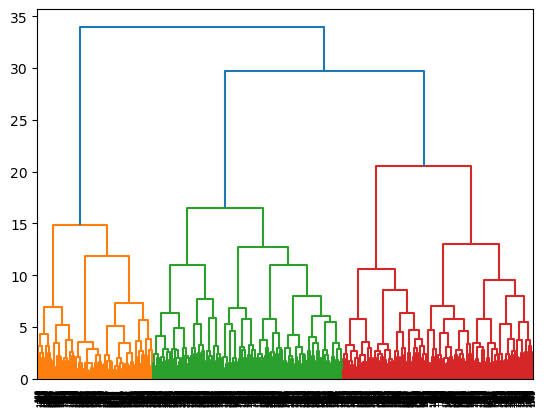

In [9]:
ward_clustering = linkage(data, method="ward", metric="euclidean")
dendrogram(ward_clustering)
plt.show()

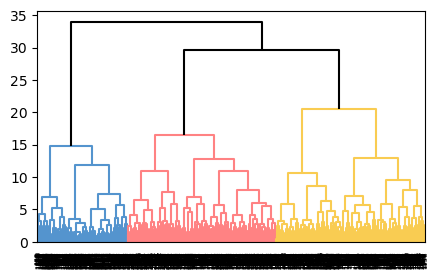

<Figure size 640x480 with 0 Axes>

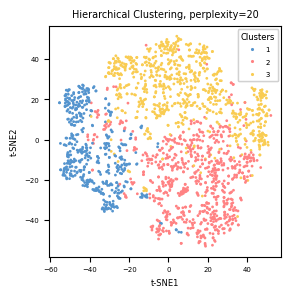

<Figure size 640x480 with 0 Axes>

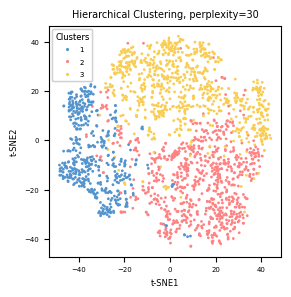

<Figure size 640x480 with 0 Axes>

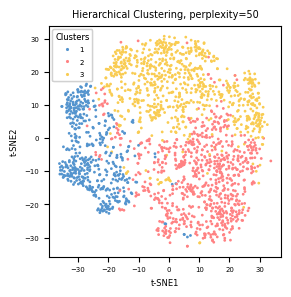

<Figure size 640x480 with 0 Axes>

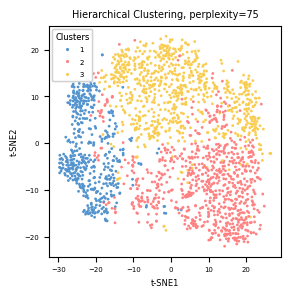

<Figure size 640x480 with 0 Axes>

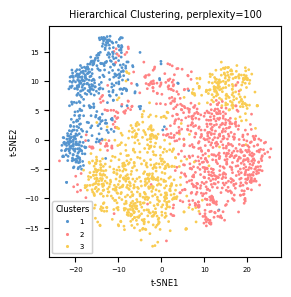

<Figure size 640x480 with 0 Axes>

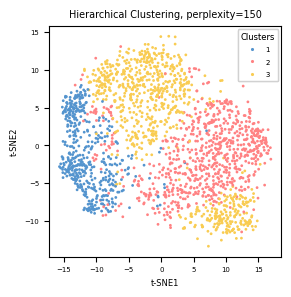

<Figure size 640x480 with 0 Axes>

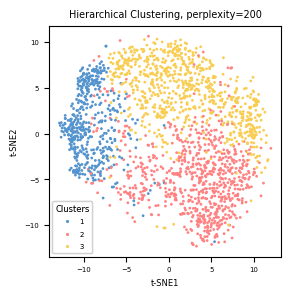

<Figure size 640x480 with 0 Axes>

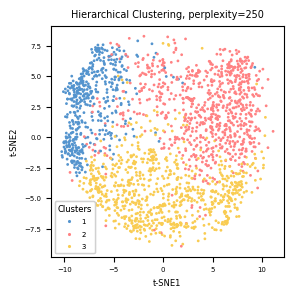

<Figure size 640x480 with 0 Axes>

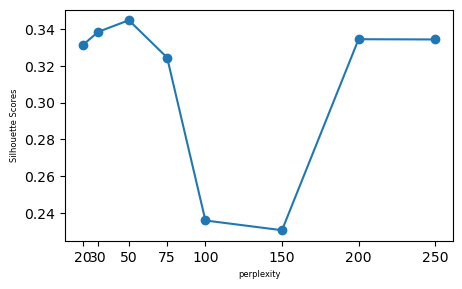

<Figure size 640x480 with 0 Axes>

In [10]:
# The parameters are determined by the plot above
rnd_seed = 42
n_clusters = 3
threshold = 25  # Adjust this threshold as needed
perplexity_list = [20, 30, 50, 75, 100, 150, 200, 250] # used for grid search

# define colors
if n_clusters == 2:
    hex_colors = ['#5494CE', '#F9CC52']
elif n_clusters == 3:
    hex_colors = ['#5494CE', '#FF8283', '#F9CC52']
elif n_clusters == 4:
    hex_colors = ['#5494CE', '#FF8283', '#0D898A', '#F9CC52']
elif n_clusters == 6:
    hex_colors = ['#f57c6e', '#f2b56f', '#84c3b7', '#71b7ed', '#b8aeeb', '#f2a7da']

# Create a ListedColormap from the hex colors
cmap = mcolors.ListedColormap(hex_colors)
hierarchy.set_link_color_palette(hex_colors)

plt.figure(figsize=(5,3))
dendrogram(ward_clustering, above_threshold_color='k', color_threshold=threshold)
plt.savefig(os.path.join(savedir,f'dendrogram_{bin_size}ms_normalized_seed{rnd_seed}_ncluster{n_clusters}.pdf'), bbox_inches='tight', transparent=True)
plt.savefig(os.path.join(savedir,f'dendrogram_{bin_size}ms_normalized_seed{rnd_seed}_ncluster{n_clusters}.png'))
plt.show()
plt.clf()

# Get cluster labels for a specific threshold
cluster_labels = fcluster(ward_clustering, threshold, criterion='distance')
label_list = pd.DataFrame({'Cluster': cluster_labels,
                           'Region': all_data['Region']})

silhouette_scores = []
for perplexity in perplexity_list:
    # Perform t-SNE to reduce dimensions
    tsne = TSNE(n_components=2, random_state=rnd_seed, perplexity=perplexity)
    reduced_data = tsne.fit_transform(data)

    silhouette_scores.append(silhouette_score(reduced_data, cluster_labels))

    colors = [cmap(label-1) for label in cluster_labels]

    # Scatter plot
    fig, ax = plt.subplots(figsize=(3,3))
    scatter = ax.scatter(reduced_data[:,0], reduced_data[:,1], c = cluster_labels, cmap=cmap, s=4, marker='o', edgecolors='none')
    legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters", title_fontsize=6, fontsize=5, markerscale=0.2)
    ax.add_artist(legend1)
    ax.set_title(f'Hierarchical Clustering, perplexity={perplexity}', fontsize=7)
    ax.set_xlabel('t-SNE1', fontsize=6)
    ax.set_ylabel('t-SNE2', fontsize=6)
    ax.tick_params(axis='x', labelsize=5)
    ax.tick_params(axis='y', labelsize=5)
    plt.savefig(os.path.join(savedir,f'tsne_hierarchical_scatter_{bin_size}ms_normalized_seed{rnd_seed}_perplexity{perplexity}_ncluster{n_clusters}.pdf'), bbox_inches='tight', transparent=True)
    plt.savefig(os.path.join(savedir,f'tsne_hierarchical_scatter_{bin_size}ms_normalized_seed{rnd_seed}_perplexity{perplexity}_ncluster{n_clusters}.png'))
    plt.show()
    plt.clf()

plt.figure(figsize=(5,3))
plt.plot(perplexity_list, silhouette_scores, '-o')
plt.xlabel('perplexity', fontsize=6)
plt.ylabel('Silhouette Scores', fontsize=6)
plt.xticks(perplexity_list)
plt.savefig(os.path.join(savedir,f'tsne_hierarchical_{bin_size}ms_normalized_seed{rnd_seed}_perplexity_gridsearch.pdf'), bbox_inches='tight', transparent=True)
plt.savefig(os.path.join(savedir,f'tsne_hierarchical_{bin_size}ms_normalized_seed{rnd_seed}_perplexity_gridsearch.png'))
plt.show()
plt.clf()


# Save labels
if opt_norm:
    label_list.to_csv(os.path.join(homedir,f'hierarchical_ClusterLabel_{monkey}_{bin_size}ms_normalized_seed{rnd_seed}_ncluster{n_clusters}_numOver{nLimit}.csv'), index=False)
else:
    label_list.to_csv(os.path.join(homedir,f'hierarchical_ClusterLabel_{monkey}_{bin_size}ms_seed{rnd_seed}_ncluster{n_clusters}_numOver{nLimit}.csv'), index=False)

The clustering results reach the highest silhouette score when perplexity = 50. 